In [ ]:
import pandas as pd
#!pip install python-levenshtein
file_path_whitelist = '/content/drive/MyDrive/Masters/Capstone Project/whitelist_final_exact.csv'
file_path_blacklist = '/content/drive/MyDrive/Masters/Capstone Project/blacklist_final_exact.csv'
file_path_ov_ev_whitelist = '/content/drive/MyDrive/Masters/Capstone Project/ov_ev_whitelist.csv'
file_path_ca_mapping = '/content/drive/MyDrive/Masters/Capstone Project/CA_MAPPING1.csv'
df_whitelist = pd.read_csv(file_path_whitelist, sep=',')
df_blacklist = pd.read_csv(file_path_blacklist, sep=',')
df_ov_ev_whitelist = pd.read_csv(file_path_ov_ev_whitelist, sep=',')
df_ca_mapping = pd.read_csv(file_path_ca_mapping, sep=',',header=None)
df_ca_mapping.columns = ['issuer_ca_id', 'ca_name']
df_whitelist['blacklist_flag'] = 0
df_blacklist['blacklist_flag'] = 1
df_whitelist['issuer_ca_id'] = df_whitelist['issuer_ca_id'].astype(int)
df_blacklist['issuer_ca_id'] = df_blacklist['issuer_ca_id'].astype(int)
df_ca_mapping['issuer_ca_id'] = df_ca_mapping['issuer_ca_id'].astype(int)

# Perform the merge
df_whitelist = df_whitelist.merge(df_ca_mapping, on='issuer_ca_id', how='left')
df_blacklist = df_blacklist.merge(df_ca_mapping, on='issuer_ca_id', how='left')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.6 MB/s eta 0:00:00


/tmp/ipython-input-3-1293004033.py:8: DtypeWarning: Columns (11,15,27,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_blacklist = pd.read_csv(file_path_blacklist, sep=',')


In [ ]:
import os

print(os.getcwd())

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

def calculate_eda_metrics(df, label):
    print(f"\n📊 EDA for {label} dataset:")
    print(df.info())

    # Parse SAN identities
    df['san_identities_list'] = df['san_identities'].apply(lambda x: json.loads(x) if pd.notnull(x) else [])
    df['no_domains'] = df['san_identities_list'].apply(len)

    # Compute validity period
    df['not_before'] = pd.to_datetime(df['not_before'])
    df['not_after'] = pd.to_datetime(df['not_after'])
    df['validity_days'] = (df['not_after'] - df['not_before']).dt.days

    # Stats: number of domains per certificate
    print(f"\nNumber of domains per certificate in {label}:")
    print(df['no_domains'].describe())

    # Stats: domain length
    df['domain_length'] = df['parsed_domainname'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
    print(f"\nDomain length stats in {label}:")
    print(df['domain_length'].describe())

    # Stats: validity period
    print(f"\nValidity period (days) stats in {label}:")
    print(df['validity_days'].describe())

    # Issuer CA analysis
    issuer_counts = df['issuer_ca_id'].value_counts().head(10)
    print(f"\nTop 10 Issuer CA IDs in {label}:\n{issuer_counts}")

    # Return the updated dataframe for further comparisons
    return df

# Run EDA for each dataset
df_blacklist = calculate_eda_metrics(df_blacklist, "Blacklist")
df_whitelist = calculate_eda_metrics(df_whitelist, "Whitelist")



📊 EDA for Blacklist dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35324 entries, 0 to 35323
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   certificate_id                                35324 non-null  int64  
 1   issuer_ca_id                                  35324 non-null  int64  
 2   serial_number                                 35324 non-null  object 
 3   not_before                                    35324 non-null  object 
 4   not_after                                     35324 non-null  object 
 5   subject_dn_json                               35324 non-null  object 
 6   san_identities                                35324 non-null  object 
 7   validation_type                               35324 non-null  object 
 8   certificate_type                              35324 non-null  object 
 9   receiver_common_name           

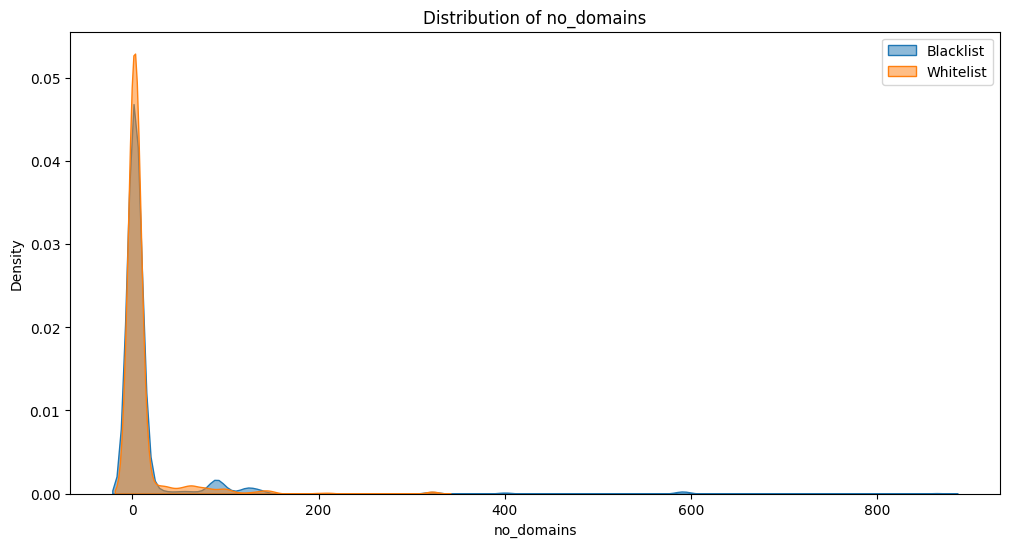

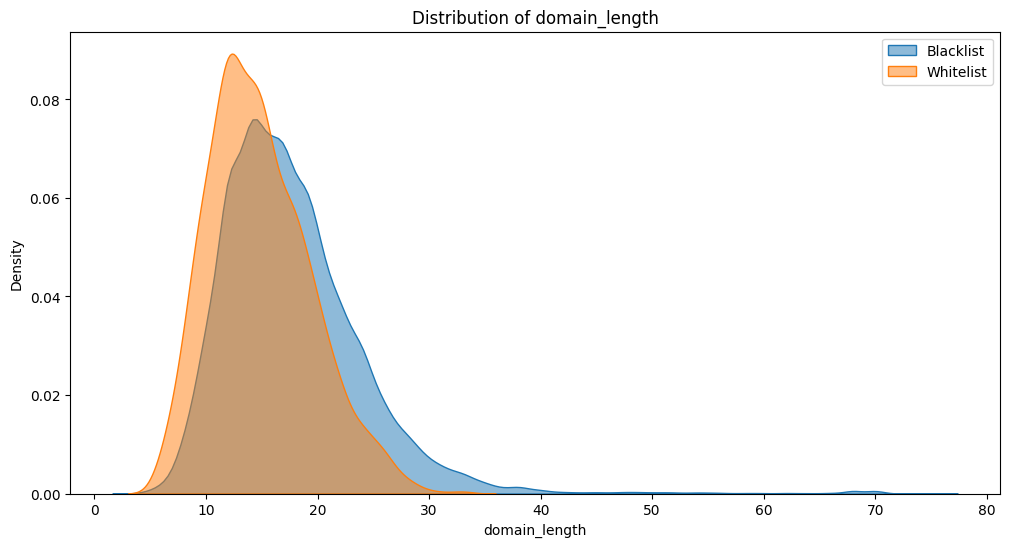

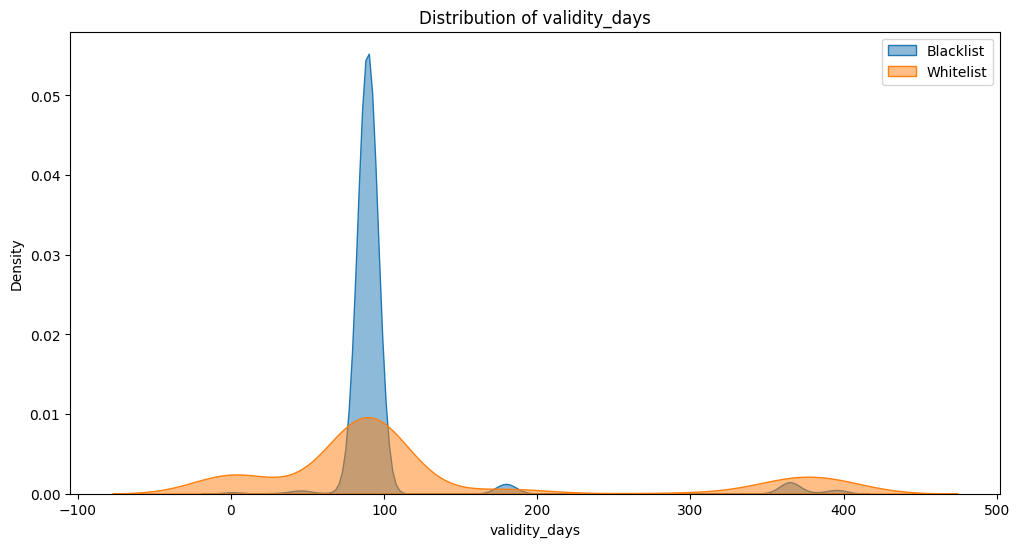

In [ ]:
def plot_metric_comparison(metric, df1, df2, label1, label2):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(df1[metric], label=label1, fill=True, alpha=0.5)
    sns.kdeplot(df2[metric], label=label2, fill=True, alpha=0.5)
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_metric_comparison('no_domains', df_blacklist, df_whitelist, 'Blacklist', 'Whitelist')
plot_metric_comparison('domain_length', df_blacklist, df_whitelist, 'Blacklist', 'Whitelist')
plot_metric_comparison('validity_days', df_blacklist, df_whitelist, 'Blacklist', 'Whitelist')


In [6]:
# Percentage of total domains for top CAs in whitelist
whitelist_total = df_whitelist.shape[0]
top_whitelist_cas = df_whitelist['ca_name'].value_counts().head(10)
top_whitelist_cas_pct = (top_whitelist_cas / whitelist_total) * 100

# Percentage of total domains for top CAs in blacklist
blacklist_total = df_blacklist.shape[0]
top_blacklist_cas = df_blacklist['ca_name'].value_counts().head(10)
top_blacklist_cas_pct = (top_blacklist_cas / blacklist_total) * 100

# Display
print("\nTop 10 CA names in whitelist (percent of total domains):")
print(top_whitelist_cas_pct)

print("\nTop 10 CA names in blacklist (percent of total domains):")
print(top_blacklist_cas_pct)



Top 10 CA names in whitelist (percent of total domains):
ca_name
Internet Security Research Group    30.799411
Google Trust Services LLC           27.072094
GlobalSign nv-sa                    18.293281
DigiCert                            12.015694
Sectigo                              7.699853
GoDaddy                              2.059833
SSL.com                              1.716528
IdenTrust Services, LLC              0.147131
SECOM Trust Systems CO., LTD.        0.098087
Taiwan-CA Inc. (TWCA)                0.049044
Name: count, dtype: float64

Top 10 CA names in blacklist (percent of total domains):
ca_name
Internet Security Research Group                        51.319216
Google Trust Services LLC                               30.882686
SSL.com                                                  5.964783
Sectigo                                                  5.135319
DigiCert                                                 2.191145
GoDaddy                                           

In [ ]:
ca_comparison_pct = pd.DataFrame({
    'Whitelist (%)': top_whitelist_cas_pct,
    'Blacklist (%)': top_blacklist_cas_pct
}).fillna(0)

print("\nIssuer CA Comparison (% of total domains):")
print(ca_comparison_pct)



Issuer CA Comparison (% of total domains):
                                                    Whitelist (%)  \
ca_name                                                             
Asseco Data Systems S.A. (previously Unizeto Ce...       0.000000   
Buypass                                                  0.000000   
DigiCert                                                12.015694   
GlobalSign nv-sa                                        18.293281   
GoDaddy                                                  2.059833   
Google Trust Services LLC                               27.072094   
IdenTrust Services, LLC                                  0.147131   
Internet Security Research Group                        30.799411   
Microsoft Corporation                                    0.000000   
SECOM Trust Systems CO., LTD.                            0.098087   
SSL.com                                                  1.716528   
Sectigo                                                  7.

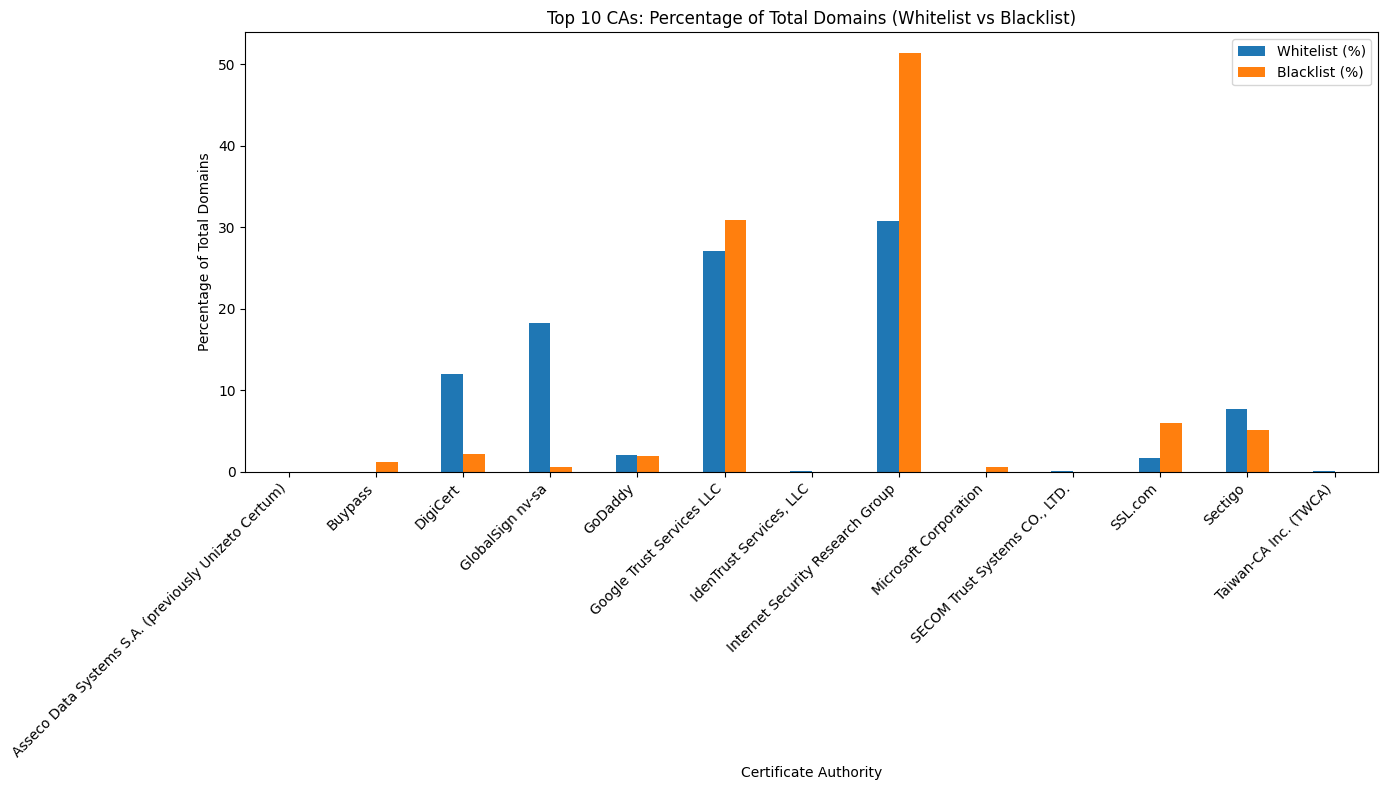

In [ ]:
import matplotlib.pyplot as plt

# Re-plot with better x-axis label handling
fig, ax = plt.subplots(figsize=(14, 8))  # wider figure for better label visibility
ca_comparison_pct.plot(kind='bar', ax=ax)

plt.title('Top 10 CAs: Percentage of Total Domains (Whitelist vs Blacklist)')
plt.ylabel('Percentage of Total Domains')
plt.xlabel('Certificate Authority')

# Rotate and right-align the labels
plt.xticks(rotation=45, ha='right')

# Optional: adjust layout for tight fit
plt.tight_layout()

plt.show()

In [5]:
df_filtered = df_blacklist[df_blacklist['validation_type'].isin(['OV', 'EV']) == False]
df_blacklist_sample = df_filtered.sample(n=2039, random_state=42)
df_whitelist_sample = df_whitelist.sample(n=2039, random_state=42)
print(df_whitelist.shape)
print(df_blacklist_sample.shape)
df_combined = pd.concat([df_whitelist, df_blacklist_sample], ignore_index=True)

(2039, 41)
(2039, 41)


In [6]:
pip install jellyfish


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 13.9 MB/s eta 0:00:00


In [22]:
df_ov_ev_whitelist1 = df_ov_ev_whitelist
#df_combined = df_combined.head(1)

In [23]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from urllib.parse import urlparse
import re
from datetime import datetime
from scipy.stats import entropy
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
import Levenshtein
import jellyfish
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import multiprocessing as mp
from functools import partial

whitelist_domains = set(df_ov_ev_whitelist1['clean_domain'].unique())

def tokenize_domain(domain):
    return re.split(r'[\.\-/_]', domain.lower())

def has_unusual_token(domain):
    tokens = set(tokenize_domain(domain))
    return int(any(token not in safe_tokens for token in tokens))

# Function: check if domain has high Jaro-Winkler similarity to any whitelist domain
def has_jaro_winkler_in_range(domain, lower=0.78, upper=0.90):
    if domain in whitelist_domains:
      return 0
    else:
      for ref_domain in whitelist_domains:
          similarity = jellyfish.jaro_winkler_similarity(domain, ref_domain)
          if lower <= similarity <= upper:
              return 1
      return 0

# Function: check if domain has small edit distance to any whitelist domain
def has_small_levenshtein(domain, threshold=2):
    for ref_domain in whitelist_domains:
        if Levenshtein.distance(domain, ref_domain) <= threshold:
            return 1
    return 0

# Helper functions
def calc_entropy(domain):
    prob = [n_x/len(domain) for x,n_x in Counter(domain).items()]
    return entropy(prob, base=2)

def count_subdomains(domain):
    return len(domain.split('.')) - 2 if '.' in domain else 0

def suspicious_keyword_present(domain):
    keywords = ['activity','online','purchase','safe','secure','bill','service','support','unlock','wallet','login',
              'log-in','signin','sign-in','verification','webscr','authenticate','credential','invoice','credential','confirm',
              'customer','office','icloud','recover','itunes','apple','security','hotmail','transaction','update','account','yahoo',
              'password,','yandex','bitconnect','verify','appleid','office365','iforgot','windows','protonmail','tutanota','bittrex',
              'gmail','google','outlook','hitbtc','google','bitfinex','bank','coinsbank','outlook','coinhive','microsoft','kraken',
              'localbitcoin','bitstamp','instagram','blockchain','bitflyer','coinbase','scottrade','lakebtc','merilledge','poloniex',
              'tumblr','bithumb','youtube','twitter','linkedin','santander','flickr','whatsapp','hsbc','ameritrade','facebook','westernunion',
              'reddit','wellsfargo','paypal','citigroup','moneygram','alibaba','bankofamerica','leboncoin','amazon','overstock',
              'github','aliexpress','skype','.orgauthorize','.org.','.com.','netflix','.comclient','.net.','.govform','morganstanley',
              'barclays','-gouvmanage','.gouv.','-com.','.netauthentication','.gov.','cgi-bin','.gouvlive']
    return int(any(kw in domain.lower() for kw in keywords))

def count_hyphens(domain):
    return domain.count('-')

def suspicious_tld(domain):
    bad_tlds = ['bank','business','cc','center','cf','click','club','country','download','ga','gb','gdn','gq','info','kim','loan',
                'men','ml','mom','online','party','pw','racing','ren','review','science','stream','study','support','tech','tk','top',
                'vip','win','work','xin','xyz']
    tld = domain.split('.')[-1]
    return int(tld in bad_tlds)

def has_inner_tld(domain):
    tlds = ['.com', '.net', '.org', '.gov', '.edu']
    return int(any(tld in domain[:-len(tld)] for tld in tlds))
def is_deeply_nested(domain, threshold=4):
    return int(count_subdomains(domain) >= threshold)

def max_jaro_winkler_similarity(domain):
    return max(
        jellyfish.jaro_winkler_similarity(domain, ref)
        for ref in whitelist_domains
    )


def apply_max_jaro_parallel(df, column_name='clean_domain', n_jobs=None):
    if n_jobs is None:
        n_jobs = mp.cpu_count()

    with Pool(n_jobs) as pool:
        results = list(tqdm(pool.imap(max_jaro_winkler_similarity, df[column_name].tolist()), total=len(df)))

    df['max_jaro_winkler_similarity'] = results
    return df

def apply_jaro_parallel_range(df, column_name='clean_domain',
                              lower=0.78, upper=0.90, n_jobs=None):
    if n_jobs is None:
        n_jobs = mp.cpu_count()

    # Fix the bounds inside the worker with functools.partial
    worker = partial(has_jaro_winkler_in_range, lower=lower, upper=upper)

    with mp.Pool(n_jobs) as pool:
        flags = pool.map(worker, df[column_name].tolist())

    new_col = f"winkler_{str(lower).replace('.','')}_{str(upper).replace('.','')}_flag"
    df[new_col] = flags
    return df

def apply_jaro_parallel(df, column_name='clean_domain'):
    with mp.Pool(mp.cpu_count()) as pool:
        sims = pool.map(max_jaro_winkler_similarity, df[column_name])
    df['max_jaro_winkler_similarity'] = sims
    return df

df = pd.DataFrame(df_combined)

# Flatten all tokens from whitelist
#domain_tokens = df['clean_domain'].apply(lambda d: ' '.join(tokenize_domain(d)))

#vectorizer = CountVectorizer(max_features=1000)  # top 100 most common tokens
#X_bow = vectorizer.fit_transform(domain_tokens)

#bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())
#df= pd.concat([df.reset_index(drop=True), bow_df], axis=1)

whitelist_tokens = df_ov_ev_whitelist1['clean_domain'].apply(tokenize_domain)
all_tokens = [token for sublist in whitelist_tokens for token in sublist if token]

# Count frequency
token_counts = Counter(all_tokens)
safe_tokens = set([token for token, count in token_counts.most_common(120000000)])

# Apply

# Sample loading (placeholder for user's merged DataFrame)
# df = pd.read_csv('merged_dataset.csv')

# Simulating input structure

# Feature creation
df['deeply_nested_subdomains'] = df['clean_domain'].apply(is_deeply_nested)
#df['validity_days'] = (df['not_after'] - df['not_before']).dt.days
#df['domain_length'] = df['clean_domain'].apply(len)
df['num_subdomains'] = df['clean_domain'].apply(count_subdomains)
df['hyphen_count'] = df['clean_domain'].apply(count_hyphens)
df['shannon_entropy'] = df['clean_domain'].apply(calc_entropy)
df['suspicious_keyword'] = df['clean_domain'].apply(suspicious_keyword_present)
df['suspicious_tld'] = df['clean_domain'].apply(suspicious_tld)
df['has_inner_tld'] = df['clean_domain'].apply(has_inner_tld)
df['issued_hour_utc'] = df['not_before'].dt.hour
df['is_weekend'] = df['not_before'].dt.dayofweek >= 5
#df['small_levenshtein_distance'] = df['clean_domain'].apply(has_small_levenshtein)
df['inner_tld_in_subdomain'] = df['clean_domain'].apply(has_inner_tld)
df['has_unusual_token'] = df['clean_domain'].apply(has_unusual_token)
#df['max_jaro_winkler_similarity'] = apply_jaro_parallel(df, column_name='clean_domain')
#df['high_jaro_winkler_similarity'] = df['clean_domain'].apply(apply_jaro_parallel_range)
#df = apply_max_jaro_parallel(df, column_name='clean_domain')
#df = apply_jaro_parallel_range(df, column_name='clean_domain')

# One-hot encoding for certificate_type and validation_type
df = pd.get_dummies(df, columns=['certificate_type', 'ca_name'], drop_first=True)
#df.to_csv('/content/drive/MyDrive/Masters/Capstone Project/features.csv', index=False)

In [20]:
df_winkler = df.copy()

In [25]:
df = pd.concat([df.reset_index(drop=True), df_winkler[['max_jaro_winkler_similarity']]], axis=1)

In [26]:
df.to_csv('/content/drive/MyDrive/Masters/Capstone Project/features.csv', index=False)

In [58]:
df = pd.get_dummies(df, columns=['certificate_type', 'ca_name'], drop_first=True)

In [18]:
file_path_features = '/content/drive/MyDrive/Masters/Capstone Project/features.csv'
df = pd.read_csv(file_path_features, sep=',')
whitelist_domains = set(df_ov_ev_whitelist['clean_domain'].unique())

In [55]:
df.columns

Index(['certificate_id', 'issuer_ca_id', 'serial_number', 'not_before',
       'not_after', 'subject_dn_json', 'san_identities', 'validation_type',
       'receiver_common_name', 'receiver_surname', 'receiver_serial_number',
       'receiver_country_name', 'receiver_locality_name',
       'receiver_state_or_province_name', 'receiver_street_address',
       'receiver_organization_name', 'receiver_organizational_unit_name',
       'receiver_title', 'receiver_description', 'receiver_business_category',
       'receiver_postal_code', 'receiver_post_office_box',
       'receiver_telephone_number', 'receiver_name', 'receiver_given_name',
       'receiver_dn_qualifier', 'receiver_organization_identifier',
       'receiver_email_address', 'receiver_unstructured_name',
       'receiver_jurisdiction_locality_name',
       'receiver_jurisdiction_state_or_province_name',
       'receiver_jurisdiction_country_name', 'parsed_domainname',
       'clean_domain', 'blacklist_flag', 'san_identities_list'

blacklist_flag                                                  1.000000
has_unusual_token                                               0.529914
shannon_entropy                                                 0.290163
suspicious_tld                                                  0.284626
num_subdomains                                                  0.277910
domain_length                                                   0.258531
ca_name_Internet Security Research Group                        0.232792
hyphen_count                                                    0.230649
inner_tld_in_subdomain                                          0.184325
has_inner_tld                                                   0.184325
certificate_type_Wildcard                                       0.180983
ca_name_SSL.com                                                 0.117326
issued_hour_utc                                                 0.086162
ca_name_Buypass                                    

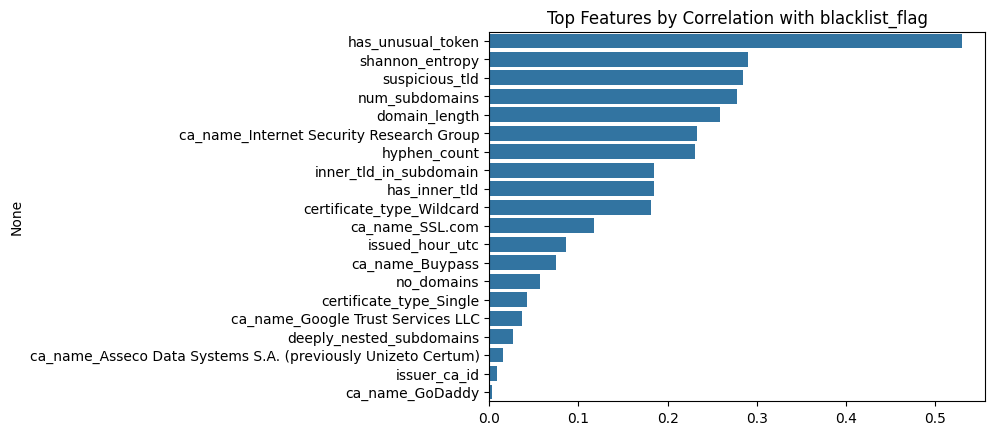

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt


# Correlation with the target
correlation = df.corr(numeric_only=True)['blacklist_flag'].sort_values(ascending=False)
print(correlation)

# Optional: visualize top features
top_corr = correlation.drop('blacklist_flag').head(20)
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top Features by Correlation with blacklist_flag")
plt.show()


In [57]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
X = df[[
    'deeply_nested_subdomains',
    'domain_length',
    'no_domains',
    'validity_days',
    'num_subdomains',
    'hyphen_count','shannon_entropy','suspicious_keyword',
    'suspicious_tld','has_inner_tld','issued_hour_utc',
    'is_weekend',
    #'vip','dev','pages','net','org','de','top','zpass',
    #'small_levenshtein_distance',
    'inner_tld_in_subdomain',
    'has_unusual_token',
     'ca_name_Asseco Data Systems S.A. (previously Unizeto Certum)',
     'ca_name_Buypass', 'ca_name_DigiCert',
     'ca_name_GlobalSign nv-sa', 'ca_name_GoDaddy',
      'ca_name_Google Trust Services LLC', 'ca_name_IdenTrust Services, LLC',
      'ca_name_Internet Security Research Group', 'ca_name_Microsoft Corporation',
      'ca_name_SECOM Trust Systems CO., LTD.',
      'ca_name_SSL.com', 'ca_name_Sectigo', 'ca_name_Taiwan-CA Inc. (TWCA)',
          'max_jaro_winkler_similarity'
          #,'high_jaro_winkler_similarity'
          ]]
y = df['blacklist_flag']

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(10))

#mi = mutual_info_classif(X, y, discrete_features='auto')
#mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
#print(mi_series.head(10))


max_jaro_winkler_similarity    0.322043
has_unusual_token              0.121227
shannon_entropy                0.116051
issued_hour_utc                0.082394
domain_length                  0.072263
no_domains                     0.054619
validity_days                  0.050148
num_subdomains                 0.039487
ca_name_GlobalSign nv-sa       0.027988
suspicious_tld                 0.023291
dtype: float64


In [69]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("Top features selected by RFE:", selected_features.tolist())


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Top features selected by RFE: ['num_subdomains', 'hyphen_count', 'suspicious_tld', 'inner_tld_in_subdomain', 'has_unusual_token', 'ca_name_Buypass', 'ca_name_DigiCert', 'ca_name_GlobalSign nv-sa', 'ca_name_SSL.com', 'max_jaro_winkler_similarity']


In [32]:
import shap
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:serial_number: object, not_before: datetime64[ns], not_after: datetime64[ns], subject_dn_json: object, san_identities: object, validation_type: object, receiver_common_name: object, receiver_serial_number: object, receiver_country_name: object, receiver_locality_name: object, receiver_state_or_province_name: object, receiver_street_address: object, receiver_organization_name: object, receiver_business_category: object, receiver_organization_identifier: object, receiver_jurisdiction_locality_name: object, receiver_jurisdiction_state_or_province_name: object, receiver_jurisdiction_country_name: object, parsed_domainname: object, clean_domain: object, san_identities_list: object

In [58]:
from sklearn.model_selection import train_test_split
selected_features = [

       'no_domains',
       'validity_days', 'domain_length', 'deeply_nested_subdomains',
       'num_subdomains', 'hyphen_count', 'shannon_entropy',
       'suspicious_keyword', 'suspicious_tld', 'has_inner_tld',
       'issued_hour_utc', 'is_weekend', 'inner_tld_in_subdomain',
       'has_unusual_token', 'certificate_type_Single',
       'certificate_type_Wildcard',
       'ca_name_Asseco Data Systems S.A. (previously Unizeto Certum)',
       'ca_name_Buypass', 'ca_name_DigiCert', 'ca_name_GlobalSign nv-sa',
       'ca_name_GoDaddy', 'ca_name_Google Trust Services LLC',
       'ca_name_IdenTrust Services, LLC',
       'ca_name_Internet Security Research Group',
       'ca_name_Microsoft Corporation',
       'ca_name_SECOM Trust Systems CO., LTD.', 'ca_name_SSL.com',
       'ca_name_Sectigo', 'ca_name_Taiwan-CA Inc. (TWCA)'
       #,'max_jaro_winkler_similarity'
]


# Keep only relevant features
features = df[selected_features]
target = df['blacklist_flag']

# First, split into train+val and test (80%/20%)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Then split train+val into train and val (75% of 80% = 60%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Confirm shapesa
split_info = {
    'Train Set': X_train.shape,
    'Validation Set': X_val.shape,
    'Test Set': X_test.shape
}

split_info


{'Train Set': (3262, 29), 'Validation Set': (612, 29), 'Test Set': (204, 29)}

In [38]:
X_train.dtypes

,0
no_domains,int64
validity_days,int64
domain_length,int64
deeply_nested_subdomains,int64
num_subdomains,int64
hyphen_count,int64
shannon_entropy,float64
suspicious_keyword,int64
suspicious_tld,int64
has_inner_tld,int64


In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=800,
    subsample=0.8,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.82      0.82      0.82       102
           1       0.82      0.81      0.82       102

    accuracy                           0.82       204
   macro avg       0.82      0.82      0.82       204
weighted avg       0.82      0.82      0.82       204



In [44]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
param_grid = {
    'n_estimators': [400,800,900],
    'max_depth': [3, 5, 7, 15, 25, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.4,0.6,0.8, 1.0],
    'colsample_bytree': [0.4,0.6,0.8, 1.0]
}

grid = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=42),
    param_grid=param_grid,
    scoring='f1',  # or 'roc_auc' if classes are imbalanced
    cv=5,
    verbose=1
)


grid.fit(X_train, y_train)
print(grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:16:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

KeyboardInterrupt: 

Validation Accuracy: 0.8545751633986928
Validation ROC AUC: 0.9426662821991542

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       306
           1       0.86      0.85      0.85       306

    accuracy                           0.85       612
   macro avg       0.85      0.85      0.85       612
weighted avg       0.85      0.85      0.85       612


Test Accuracy: 0.8137254901960784
Test ROC AUC: 0.9155132641291812

Test Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       102
           1       0.82      0.80      0.81       102

    accuracy                           0.81       204
   macro avg       0.81      0.81      0.81       204
weighted avg       0.81      0.81      0.81       204



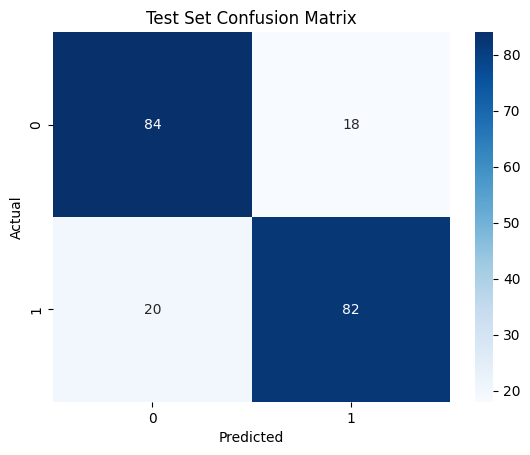

In [45]:
# Step 1: Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Initialize and train the model
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
model.fit(X_train, y_train)

# Step 3: Predict on validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Optional: Probabilities for ROC AUC
y_val_proba = model.predict_proba(X_val)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# Step 4: Evaluate performance
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_proba))
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Step 5: Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
import pickle

# Define the file path in your Google Drive (adjust the folder as needed)
model_path = '/content/drive/MyDrive/Masters/Capstone Project/models/random_forest_model.pkl'

# Save the model
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

print(f'Model saved to {model_path}')

Model saved to /content/drive/MyDrive/Masters/Capstone Project/models/random_forest_model.pkl


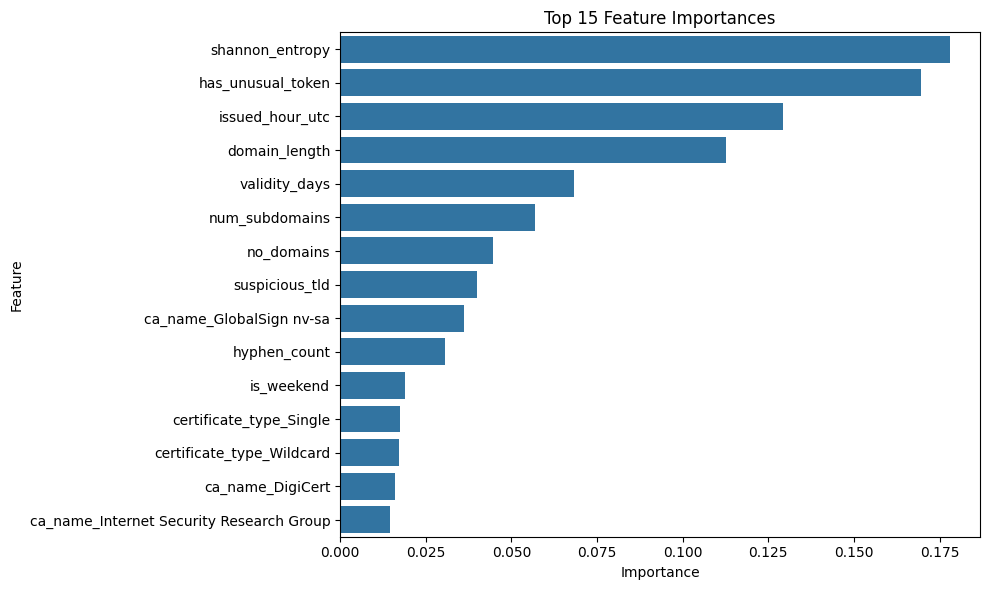

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# If using XGBoost or RandomForest
importances = model.feature_importances_
features = X_train.columns  # or X_train.columns if using a DataFrame
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200,800],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}


In [52]:
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',  # or 'roc_auc' if you're prioritizing AUC
    cv=3,
    verbose=1,
    n_jobs=-1  # use all cores
)

# Fit on training set
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 800]},
             scoring='roc_auc', verbose=1)

In [53]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
Best Score: 0.9318486113367999


Validation Accuracy: 0.8186274509803921
Test ROC AUC: 0.9123414071510958
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       102
           1       0.83      0.80      0.82       102

    accuracy                           0.82       204
   macro avg       0.82      0.82      0.82       204
weighted avg       0.82      0.82      0.82       204



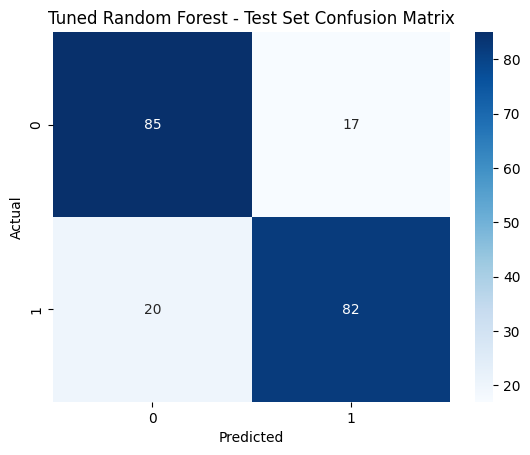

In [54]:
best_rf = grid_search.best_estimator_
y_test_pred = best_rf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Validation Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_test_pred))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Tuned Random Forest - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Validation Accuracy: 0.8235294117647058
Validation ROC AUC: 0.9106006236917424

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       306
           1       0.83      0.82      0.82       306

    accuracy                           0.82       612
   macro avg       0.82      0.82      0.82       612
weighted avg       0.82      0.82      0.82       612


Test Accuracy: 0.7450980392156863
Test ROC AUC: 0.8285755478662054

Test Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       102
           1       0.78      0.68      0.73       102

    accuracy                           0.75       204
   macro avg       0.75      0.75      0.74       204
weighted avg       0.75      0.75      0.74       204



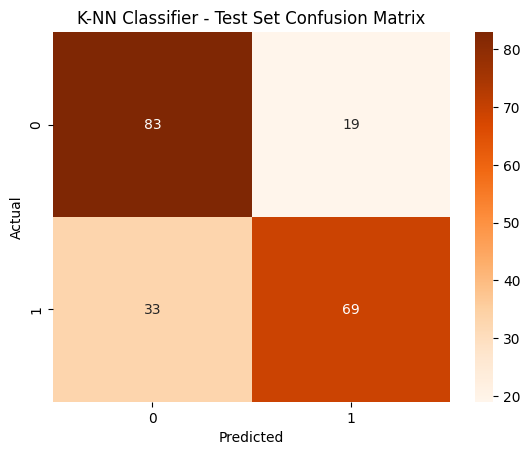

In [51]:
# Step 1: Import libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Scale features (important for distance-based models like K-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train K-NN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can tune this
knn_model.fit(X_train_scaled, y_train)

# Step 4: Predict
y_val_pred = knn_model.predict(X_val_scaled)
y_test_pred = knn_model.predict(X_test_scaled)

# Probability estimates for AUC
y_val_proba = knn_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba = knn_model.predict_proba(X_test_scaled)[:, 1]

# Step 5: Evaluate
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_proba))
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Step 6: Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('K-NN Classifier - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Validation Accuracy: 0.803921568627451
Validation ROC AUC: 0.8953821179888077

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       306
           1       0.76      0.90      0.82       306

    accuracy                           0.80       612
   macro avg       0.82      0.80      0.80       612
weighted avg       0.82      0.80      0.80       612


Test Accuracy: 0.7745098039215687
Test ROC AUC: 0.8484236831987697

Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       102
           1       0.76      0.79      0.78       102

    accuracy                           0.77       204
   macro avg       0.77      0.77      0.77       204
weighted avg       0.77      0.77      0.77       204



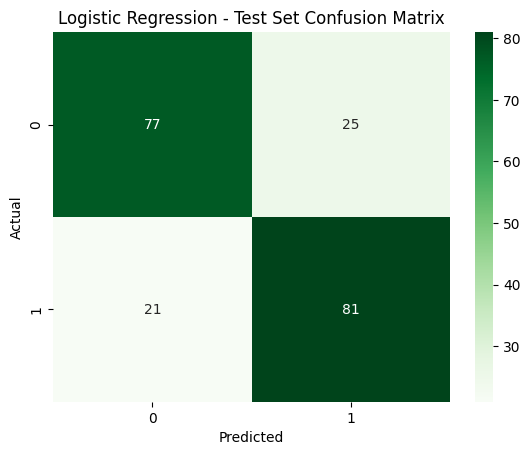

In [213]:
# Step 1: Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Initialize and train the model
lr_model = LogisticRegression(
    max_iter=1000,          # Increase iterations to ensure convergence
    class_weight='balanced',  # Useful for imbalanced classes
    solver='liblinear',     # Good for small to medium datasets
    random_state=42
)
lr_model.fit(X_train, y_train)

# Step 3: Predict on validation and test sets
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

# Get probability estimates for AUC
y_val_proba = lr_model.predict_proba(X_val)[:, 1]
y_test_proba = lr_model.predict_proba(X_test)[:, 1]

# Step 4: Evaluate performance
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_proba))
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Step 5: Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Logistic Regression - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
